==================================================================
### Code developed by: Vinicius Luiz Santos Silva

### Contact: v.santos-silva19@imperial.ac.uk / viluiz@gmail.com
==================================================================

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import gzip

# To Load data

In [2]:
def readtimesteps(folder, prefix, start, end, extension):
    
    times = []; values = []    
    
    for i in range(start,end+1):
        file = folder + '/' + prefix + str(i) + extension    

        #with open(file, 'r') as f:
        with gzip.open(file, 'r') as f:
            for line in f:
                line = line.decode() # because of gzip
                if 'groups' in line and i == start:
                    groups = line.replace(',',' ').split()[5:]
                if 'TIME' in line:
                    newtime = True
                    break

            while newtime:
                newtime = False
                times.append(float(line.replace(',',' ').split()[2]))

                values_per_time = []
                for line in f:
                    line = line.decode() # because of gzip
                    if 'GROUP' in line:
                        continue
                    if 'TIME' in line:
                        newtime = True
                        break
                    values_per_time.append([float(x) for x in line.strip().split() if x != ''])  
                values.append(values_per_time)
            
            
    return times, groups, values

In [3]:
def readR0(file):
    values = []
    with open(file) as f:
        for line in f:
            if '#' in line or line.strip() == '':
                continue
            values += list(map(float,line.split(',')))
    return values

# Training dataset

In [4]:
times, groups, values = readtimesteps(folder = '../datasets/lots_run_small/run_1',
                                  prefix = 'group-output-time',
                                  start = 1,
                                  end = 983,
                                  extension = '.csv.gz')

In [5]:
R0 = readR0('../datasets/lots_run_small/run_1/r0-2values.csv')

In [6]:
times = np.array(times)
values = np.array(values)

print('# of times: ', len(times))
print('# of groups: ', len(groups))
print('values.shape: ', values.shape)
print('R0: ', R0)


# of times:  983
# of groups:  8
values.shape:  (983, 80, 10)
R0:  [9.10159074688, 10.0869534397]


In [7]:
nrun = 40
runs = []
R0s = []
for i in range(nrun):
    times, groups, values = readtimesteps(folder = '../datasets/lots_run_small/run_' + str(i+1),
                                  prefix = 'group-output-time',
                                  start = 1,
                                  end = 983,
                                  extension = '.csv.gz')
    R0 = readR0('../datasets/lots_run_small/run_' +str(i+1)+ '/r0-2values.csv')
    runs.append(np.array(values))
    R0s.append(np.array(R0))

In [8]:
np.shape(runs)

(40, 983, 80, 10)

In [9]:
np.shape(R0s)

(40, 2)

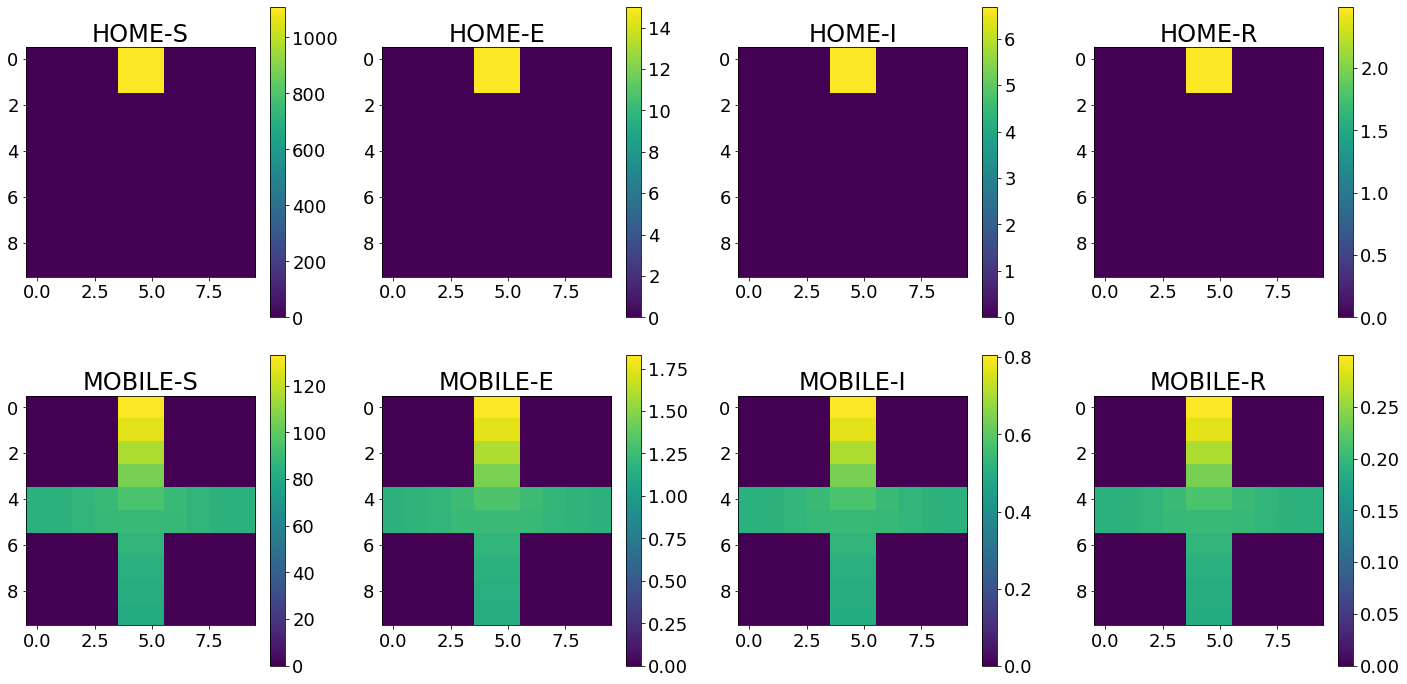

In [10]:
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=18) 
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(runs[0][200,i*10:(i+1)*10,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)
plt.tight_layout()
#plt.savefig('meshnum_2000.png')

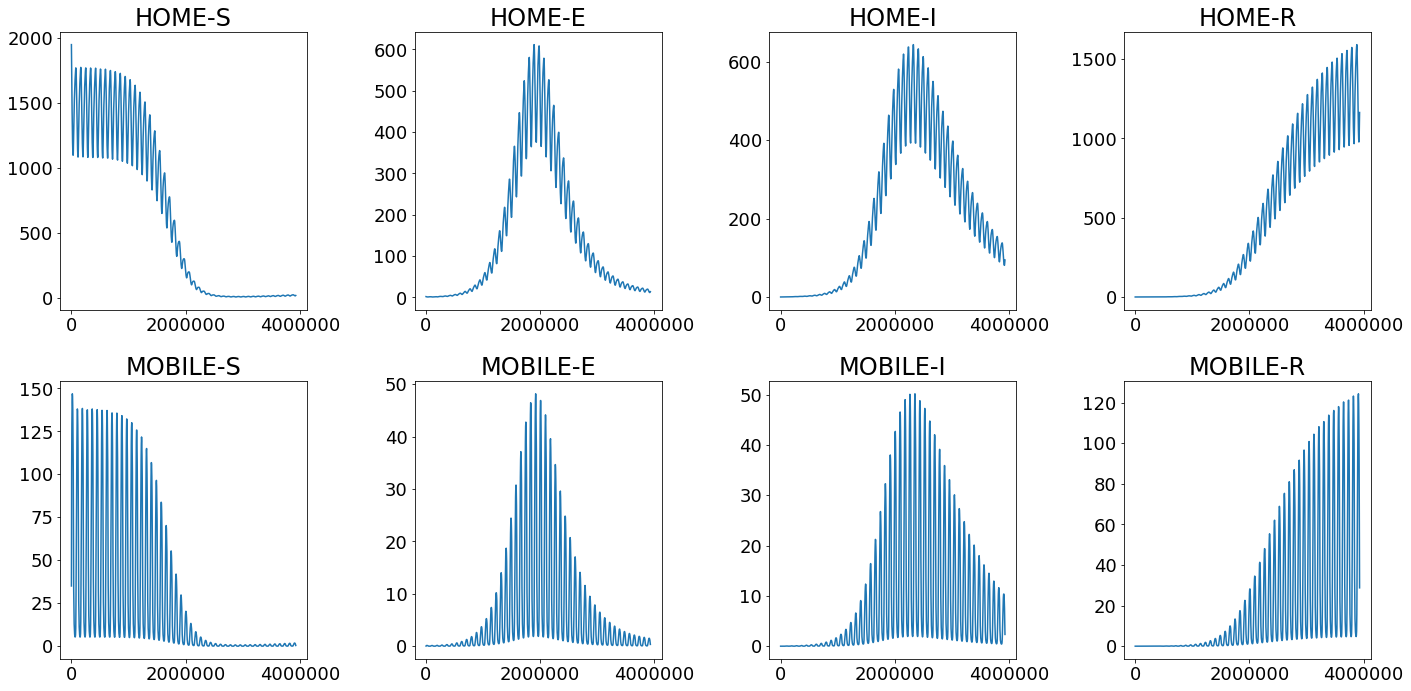

In [11]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(times, runs[0][:,i*10,4])
    ax.flatten()[i].set_title(group)
plt.tight_layout()

## Prepare the data

In [12]:
nl = int(runs[0].shape[-1])
nc = int(runs[0].shape[-2]/len(groups))
print('Grid: ', nl, 'x',nc)

Grid:  10 x 10


In [13]:
X_train_2D = np.reshape(runs,(nrun*len(times), len(groups)*nl, nc))

In [14]:
X_train_2D.shape

(39320, 80, 10)

In [15]:
X_train_3D = X_train_2D.reshape(nrun*len(times),len(groups),nl,nc)

In [16]:
X_train_3D.shape 

(39320, 8, 10, 10)

In [17]:
X_train_1D = X_train_2D.reshape(nrun*len(times),len(groups)*nl*nc)

In [18]:
X_train_1D.shape

(39320, 800)

In [19]:
def calculateerror(X_train_3D, X_train_3D_recovered, groups, print_step = 0):
    abs_error = abs(X_train_3D - X_train_3D_recovered)
    perc_error = abs_error*100/abs(X_train_3D)
    
    print('max_abs_error: ',np.max(abs(X_train_3D - X_train_3D_recovered)) )
    print('mean_abs_error: ',np.mean(abs(X_train_3D - X_train_3D_recovered)) )
    
    if print_step:
        for time in range(0,X_train_3D.shape[0],print_step):
            print('\ntime: ',time)
            for i, group in enumerate(groups):
                print('Group '+group+': max_abs_error = ',
                      round(np.max(abs_error[time,i,:,:]) ,4),
                      ' %_mae = ',
                      round( np.max(perc_error[time,i,::][np.isfinite(perc_error[time,i,::])]) ,4),
                      '%')

## Dimensionality reduction - PCA

In [20]:
from sklearn.decomposition import PCA

pca = PCA(X_train_1D.shape[1])
X_train_pca = pca.fit_transform(X_train_1D)

In [21]:
X_recovered = pca.inverse_transform(X_train_pca)
np.allclose(X_recovered, X_train_1D)

True

In [22]:
#print(pca.singular_values_**2/(X_train_1D.shape[0]-1))
#print()
#print(pca.explained_variance_)
#print(pca.explained_variance_ratio_)

In [23]:
p = 0.9999995
cumsum_eig = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum_eig >= p) + 1
d

15

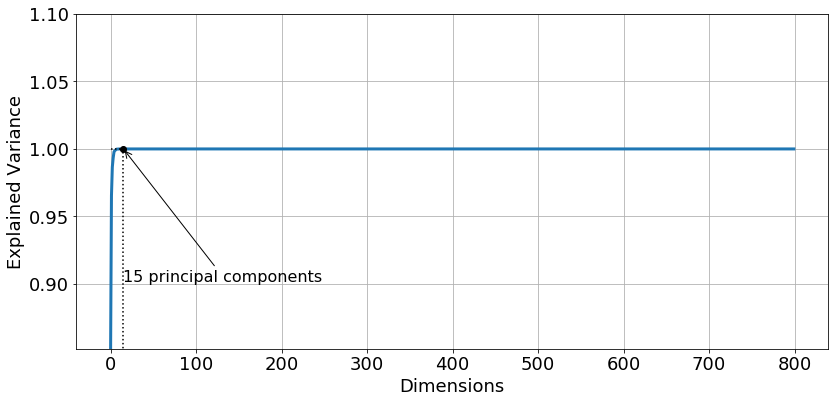

In [24]:
plt.figure(figsize=(12,6))
plt.plot(cumsum_eig, linewidth=3)
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.ylim([cumsum_eig[0],1.1])
plt.plot([d, d], [0, p], "k:")
plt.plot([0, d], [p, p], "k:")
plt.plot(d, p, "ko")
plt.annotate("15 principal components", xy=(d, p), xytext=(d, cumsum_eig[0]+0.05),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
p = 0.9999995
cumsum_sv = np.cumsum(pca.singular_values_**2/sum(pca.singular_values_**2))
d = np.argmax(cumsum_sv >= p) + 1
d

15

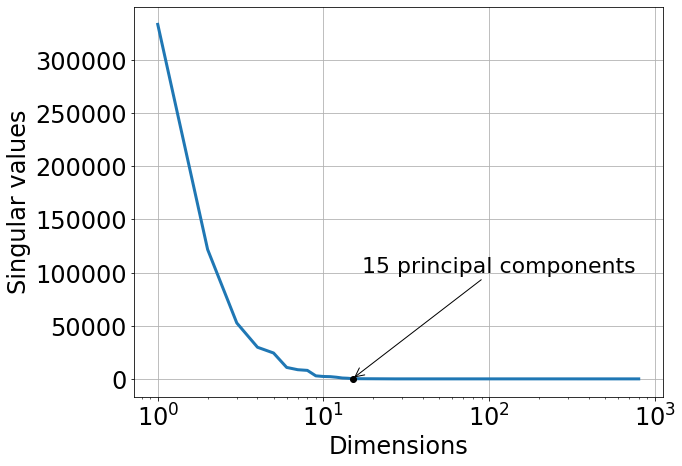

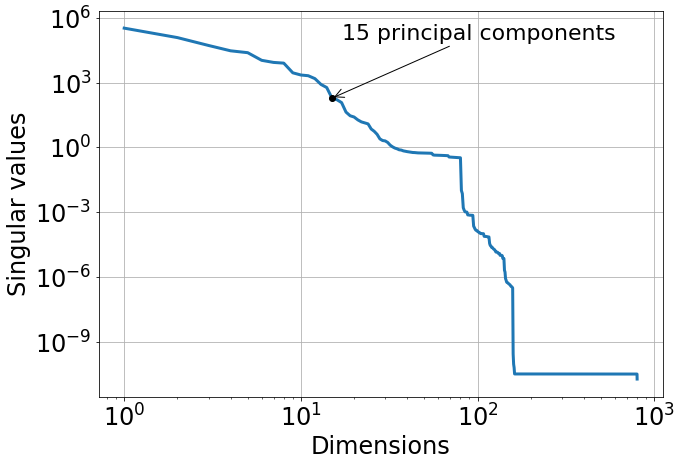

In [26]:
# Plot forward and backward march   
mpl.rcParams.update({'font.size': 24})
mpl.rc('xtick', labelsize=24) 
mpl.rc('ytick', labelsize=24) 
mpl.rc('axes', labelsize=24)

fig, ax = plt.subplots(1,1,figsize=[10,7])
ax.plot(range(1,len(pca.singular_values_)+1), pca.singular_values_, linewidth=3)
ax.set_xlabel("Dimensions")
ax.set_ylabel("Singular values")
ax.set_xscale('log') 
#ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
#plt.yscale('log') 
ax.plot(d, pca.singular_values_[d-1], "ko")
ax.annotate("15 principal components", xy=(d, pca.singular_values_[d-1]), xytext=(d+2, 1e5),
             arrowprops=dict(arrowstyle="->"), fontsize=22)
ax.grid()
#ax.grid(True, which="both", ls="-", color='0.65')
plt.tight_layout()
#plt.savefig('PCA_sv1.eps')

fig, ax = plt.subplots(1,1,figsize=[10,7])
ax.plot(range(1,len(pca.singular_values_)+1), pca.singular_values_, linewidth=3)
ax.set_xlabel("Dimensions")
ax.set_ylabel("Singular values")
ax.set_xscale('log') 
#ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax.set_yscale('log') 
ax.plot(d, pca.singular_values_[d-1], "ko")
ax.annotate("15 principal components", xy=(d, pca.singular_values_[d-1]), xytext=(d+2, 1e5),
             arrowprops=dict(arrowstyle="->"), fontsize=22)
ax.grid()
#ax.grid(True, which="both", ls="-", color='0.65')
plt.tight_layout()
#plt.savefig('PCA_sv2.eps')

### Build the model - PCA

In [27]:
pca_compress = PCA(n_components=15)
X_train_pca = pca_compress.fit_transform(X_train_1D)
X_recovered = pca_compress.inverse_transform(X_train_pca)
np.allclose(X_recovered, X_train_1D)

False

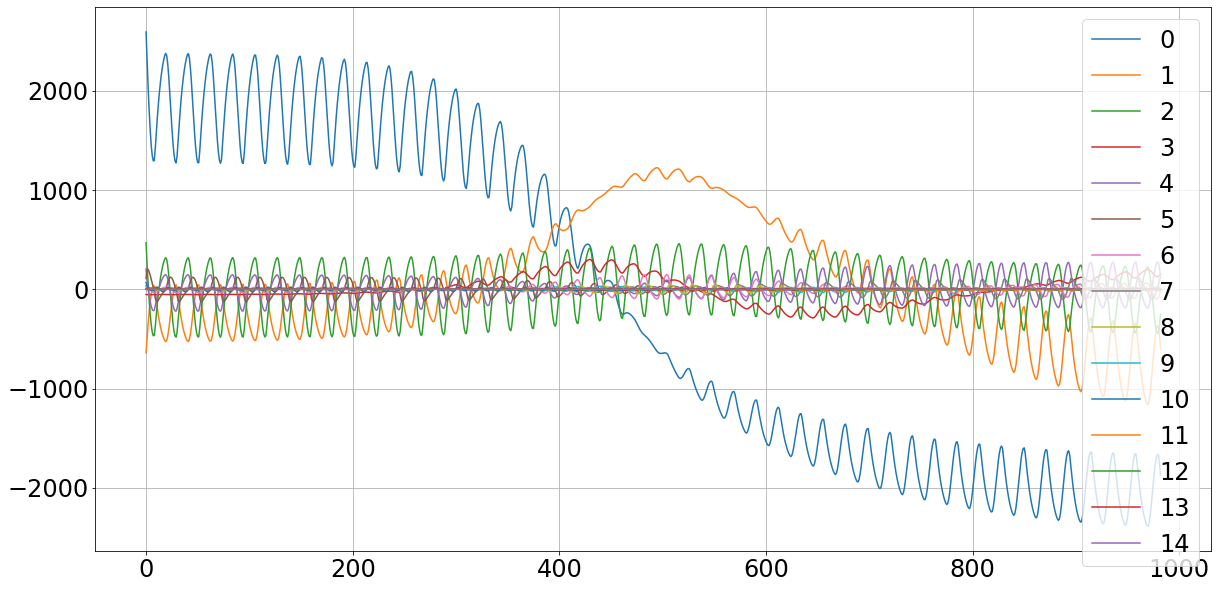

In [28]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(X_train_pca[:len(times)*1]);
ax.grid()
ax.legend(range(15))

In [29]:
import joblib
joblib.dump(pca_compress, "pca_compress_15.pkl") 
np.savetxt('X_train_1D.csv', X_train_1D, delimiter=',') 
np.savetxt('X_train_pca.csv', X_train_pca, delimiter=',') 
np.savetxt('R0s.csv', R0s, delimiter=',') 
np.savetxt('times.csv', times, delimiter=',') 
with open('groups.txt','w') as f:
    f.writelines([g + '\n' for g in groups])

#...
# pca_compress = joblib.load("pca_compress_15.pkl") 
# X_train_compressed = np.loadtxt('X_train_pca.csv', delimiter=',') 

# X_train_1D = np.loadtxt('X_train_1D.csv', delimiter=',') 
# times  = np.loadtxt('times.csv', delimiter=',') 
# with open('groups.txt') as f:
#     groups = [g.strip() for g in f.readlines()]

# # PCA recovered
# X_recovered = pca_compress.inverse_transform(X_train_compressed)

In [30]:
calculateerror(X_train_1D.reshape(nrun*len(times),len(groups),nl,nc), 
               X_recovered.reshape(nrun*len(times),len(groups),nl,nc), 
               groups,
               print_step=0)

max_abs_error:  2.1084948327912905
mean_abs_error:  0.006324655371374625


/home/viluiz/anaconda3/envs/py3ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/viluiz/anaconda3/envs/py3ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


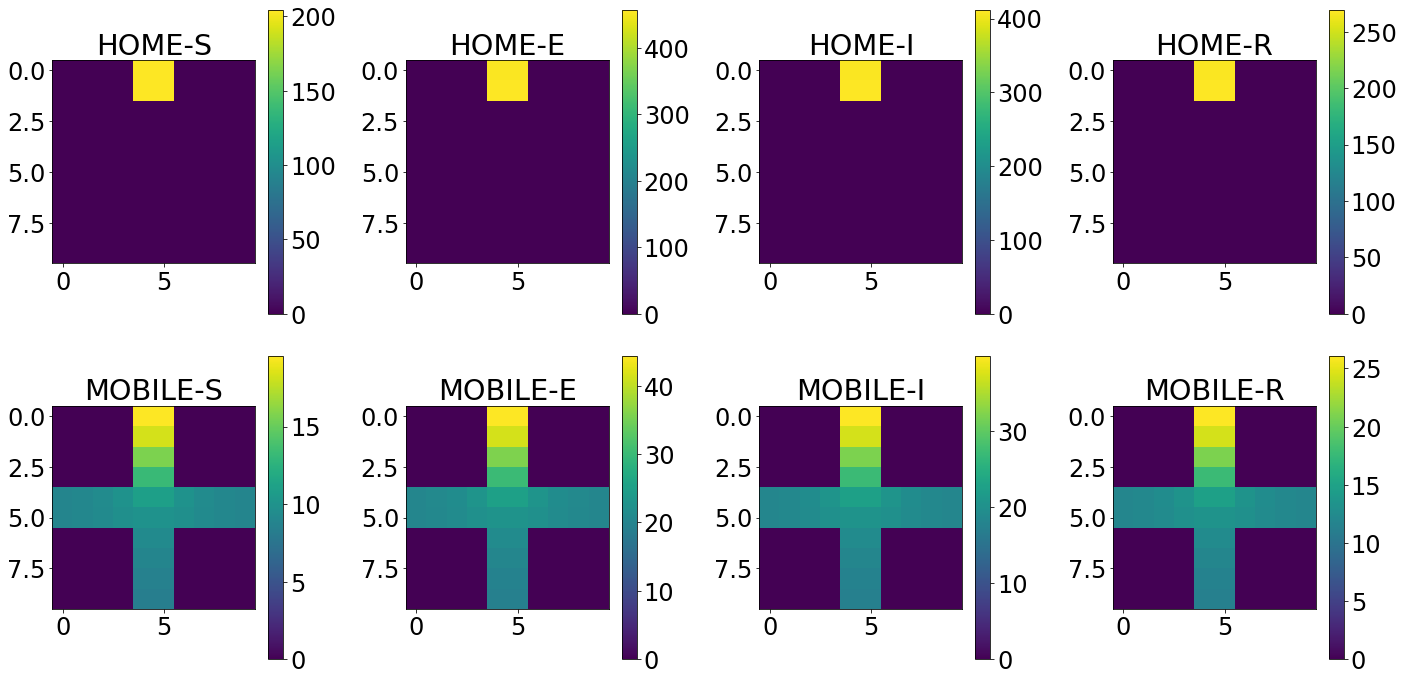

In [31]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_train_1D.reshape(nrun,len(times),len(groups),nl,nc)[0, 500,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)
plt.tight_layout()

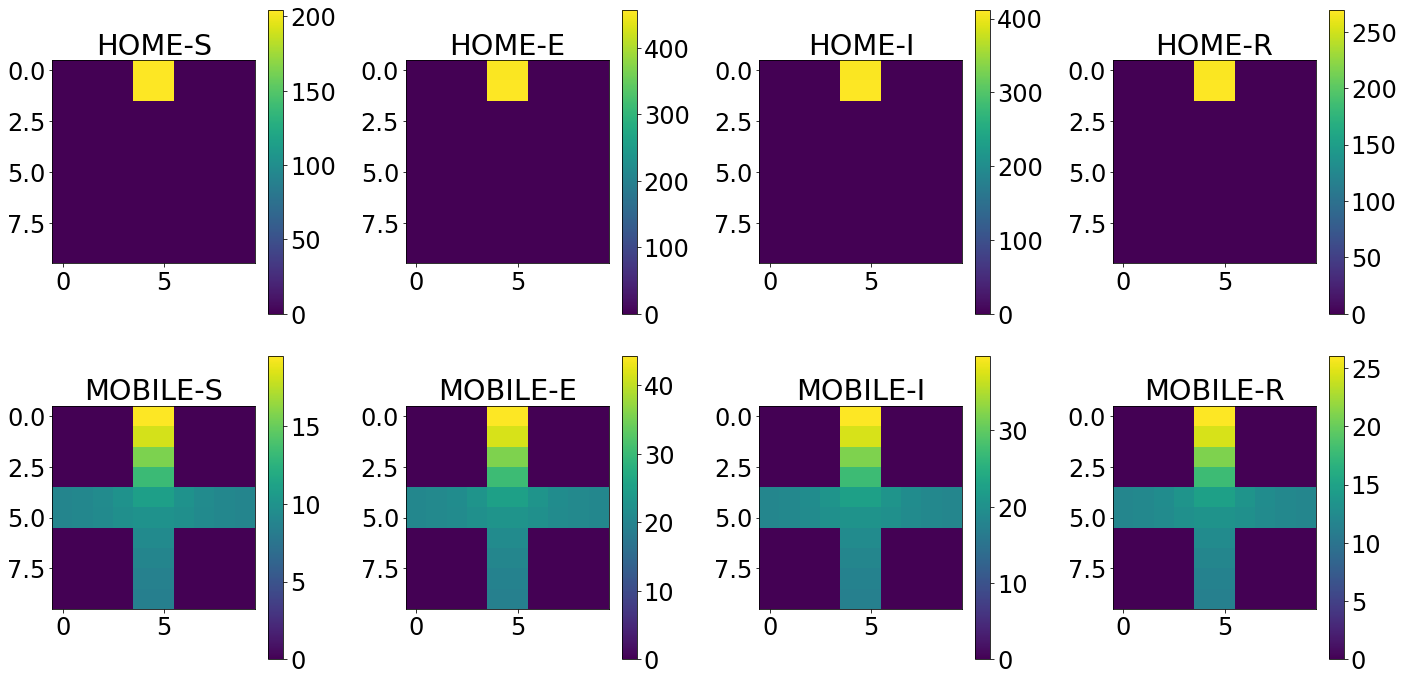

In [32]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_recovered.reshape(nrun, len(times),len(groups),nl,nc)[0, 500,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)
plt.tight_layout()

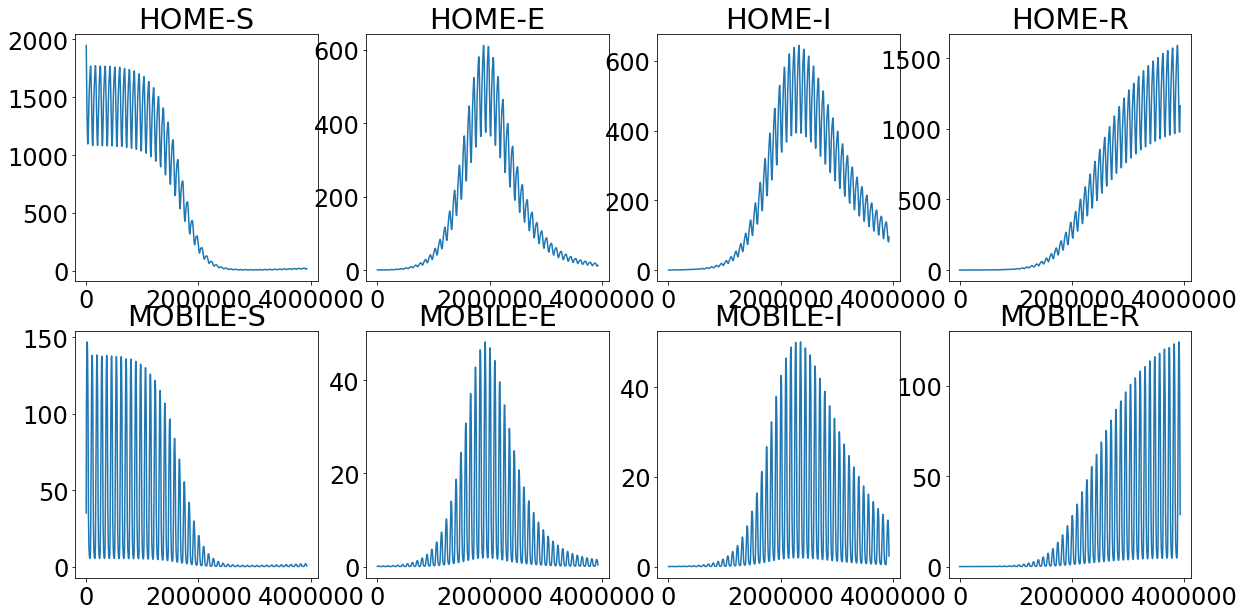

In [33]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(times, X_train_1D.reshape(nrun, len(times),len(groups),nl,nc)[0,:,i,0,4])
    ax.flatten()[i].set_title(group)

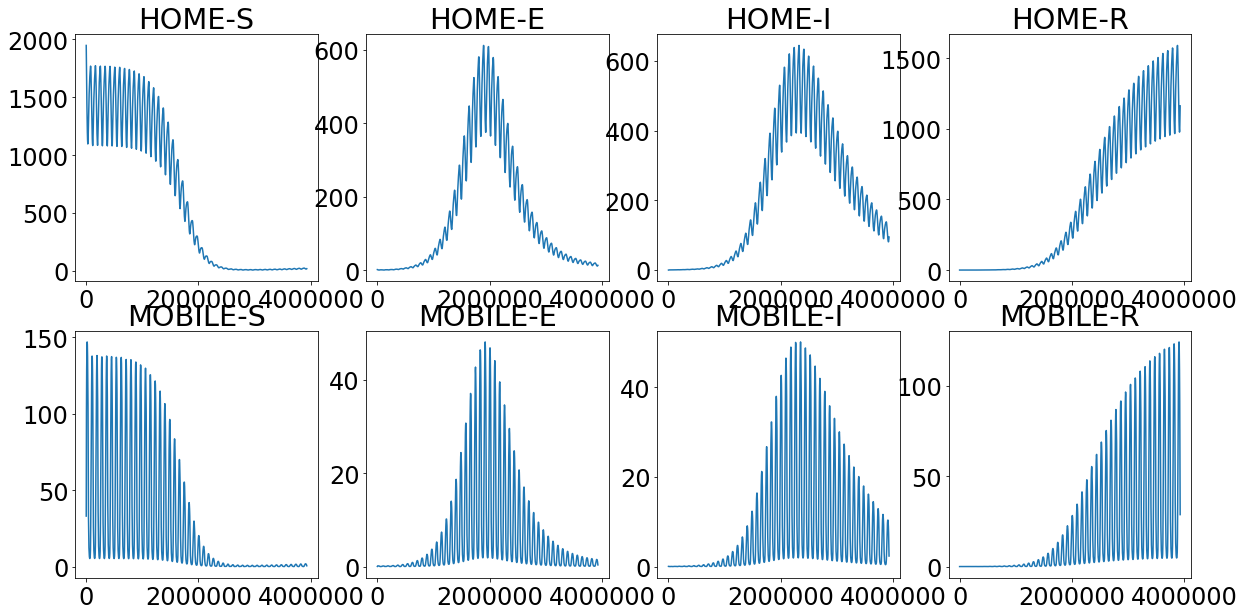

In [34]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(times, X_recovered.reshape(nrun, len(times),len(groups),nl,nc)[0,:,i,0,4])
    ax.flatten()[i].set_title(group)

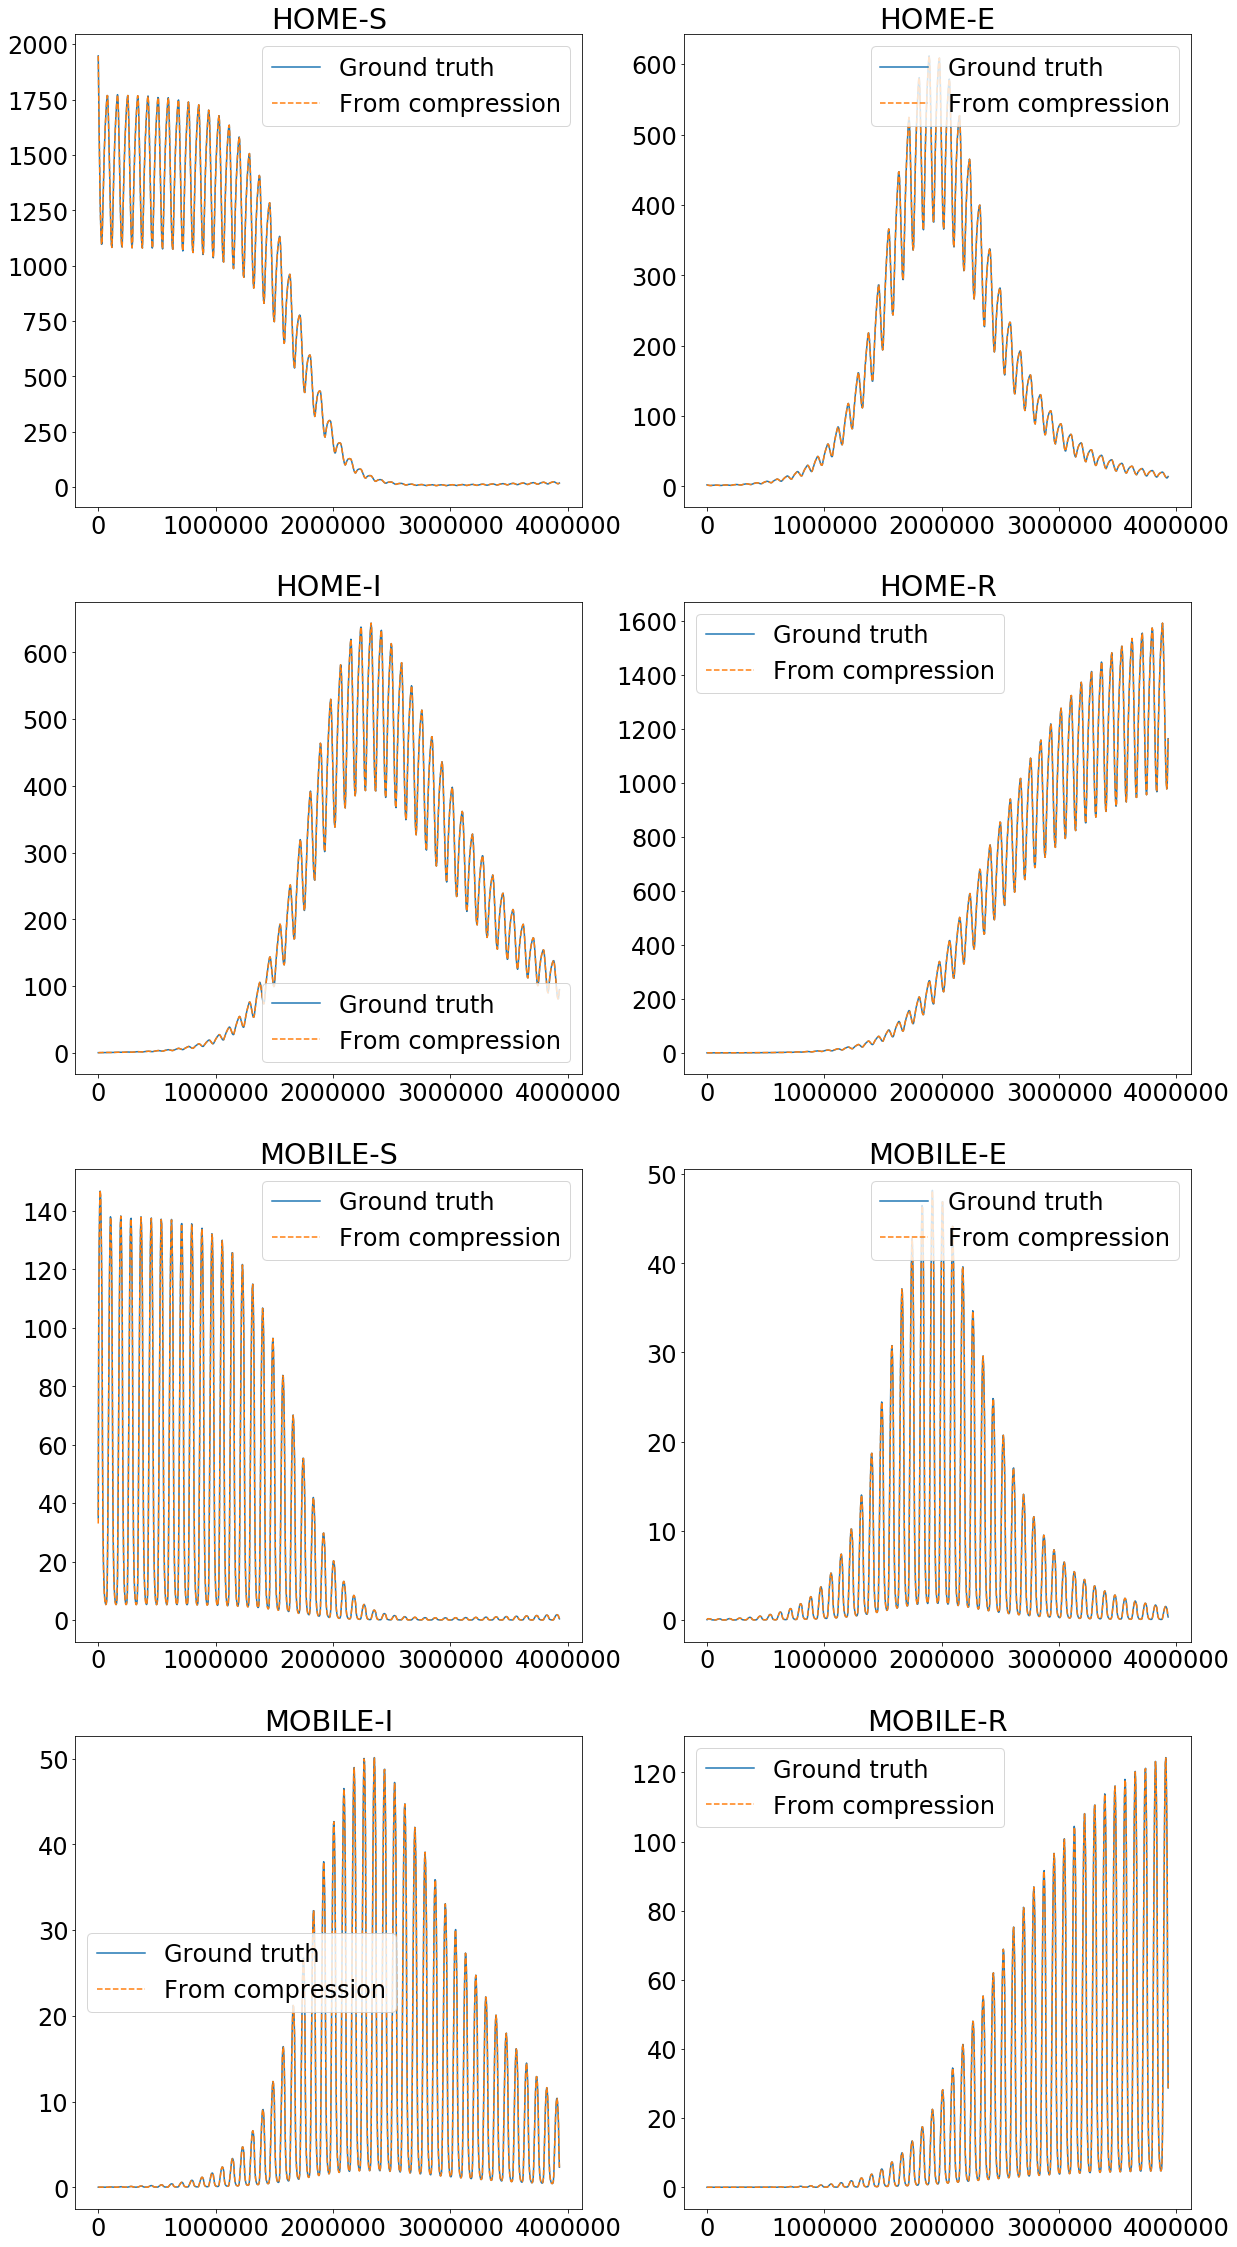

In [35]:
fig, ax = plt.subplots(4,2, figsize=[20,40])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(times, X_train_1D.reshape(nrun, len(times),len(groups),nl,nc)[0,:,i,0,4], label='Ground truth')
    ax.flatten()[i].plot(times, X_recovered.reshape(nrun, len(times),len(groups),nl,nc)[0,:,i,0,4],'--', label='From compression')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()

# Test dataset

In [36]:
times, groups, values = readtimesteps(folder = '../datasets/lots_run_small2/run_1',
                                  prefix = 'group-output-time',
                                  start = 1,
                                  end = 983,
                                  extension = '.csv.gz')

In [37]:
R0 = readR0('../datasets/lots_run_small2/run_1/r0-2values.csv')

In [38]:
times = np.array(times)
values = np.array(values)

print('# of times: ', len(times))
print('# of groups: ', len(groups))
print('values.shape: ', values.shape)
print('R0: ', R0)


# of times:  983
# of groups:  8
values.shape:  (983, 80, 10)
R0:  [1.48693924187, 2.58914367665]


In [39]:
nrun = 40
runs = []
R0s = []
for i in range(nrun):
    times, groups, values = readtimesteps(folder = '../datasets/lots_run_small2/run_' + str(i+1),
                                  prefix = 'group-output-time',
                                  start = 1,
                                  end = 983,
                                  extension = '.csv.gz')
    R0 = readR0('../datasets/lots_run_small2/run_' +str(i+1)+ '/r0-2values.csv')
    runs.append(np.array(values))
    R0s.append(np.array(R0))

In [40]:
np.shape(runs)

(40, 983, 80, 10)

In [41]:
np.shape(R0s)

(40, 2)

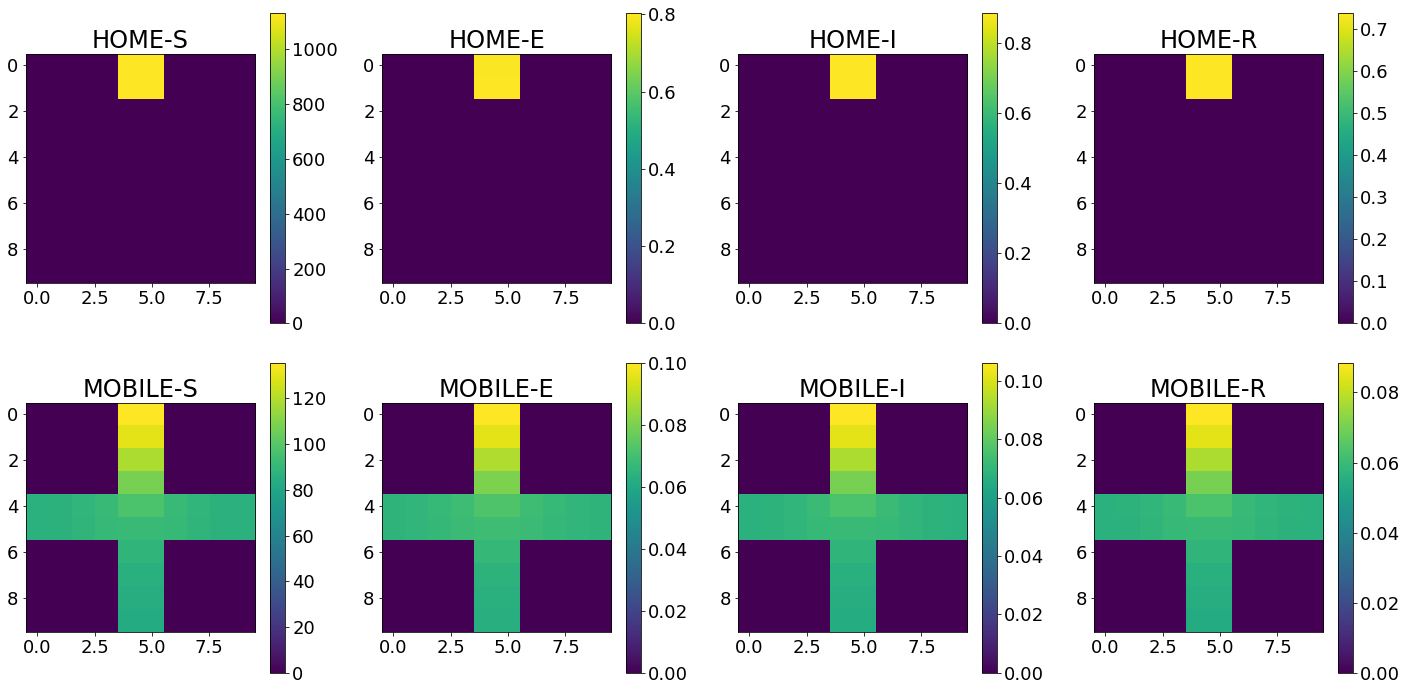

In [42]:
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=18) 
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(runs[0][200,i*10:(i+1)*10,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)
plt.tight_layout()
#plt.savefig('meshnum_2000.png')

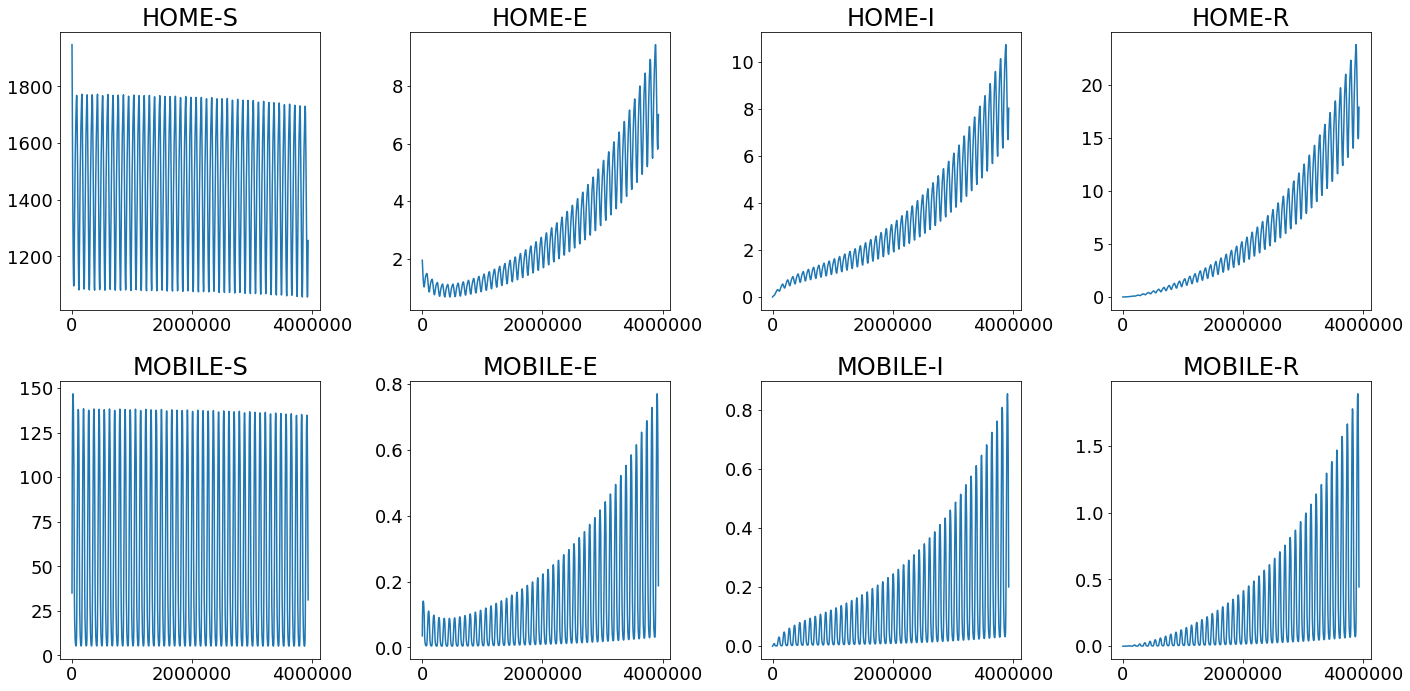

In [43]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(times, runs[0][:,i*10,4])
    ax.flatten()[i].set_title(group)
plt.tight_layout()

## Prepare the data

In [44]:
nl = int(runs[0].shape[-1])
nc = int(runs[0].shape[-2]/len(groups))
print('Grid: ', nl, 'x',nc)

Grid:  10 x 10


In [45]:
X_test_2D = np.reshape(runs,(nrun*len(times), len(groups)*nl, nc))

In [46]:
X_test_2D.shape

(39320, 80, 10)

In [47]:
X_test_3D = X_test_2D.reshape(nrun*len(times),len(groups),nl,nc)

In [48]:
X_test_3D.shape 

(39320, 8, 10, 10)

In [49]:
X_test_1D = X_test_2D.reshape(nrun*len(times),len(groups)*nl*nc)

In [50]:
X_test_1D.shape

(39320, 800)

In [51]:
import joblib

np.savetxt('X_test_1D.csv', X_test_1D, delimiter=',') 
np.savetxt('R0s_test.csv', R0s, delimiter=',') 
#np.savetxt('times.csv', times, delimiter=',') 
#with open('groups.txt','w') as f:
#    f.writelines([g + '\n' for g in groups])

#pca_compress = joblib.load("pca_compress_15.pkl") 
X_test_pca = pca_compress.transform(X_test_1D)
np.savetxt('X_test_pca.csv', X_test_pca, delimiter=',') 
X_recovered = pca_compress.inverse_transform(X_test_pca)
np.allclose(X_recovered, X_test_1D)

False

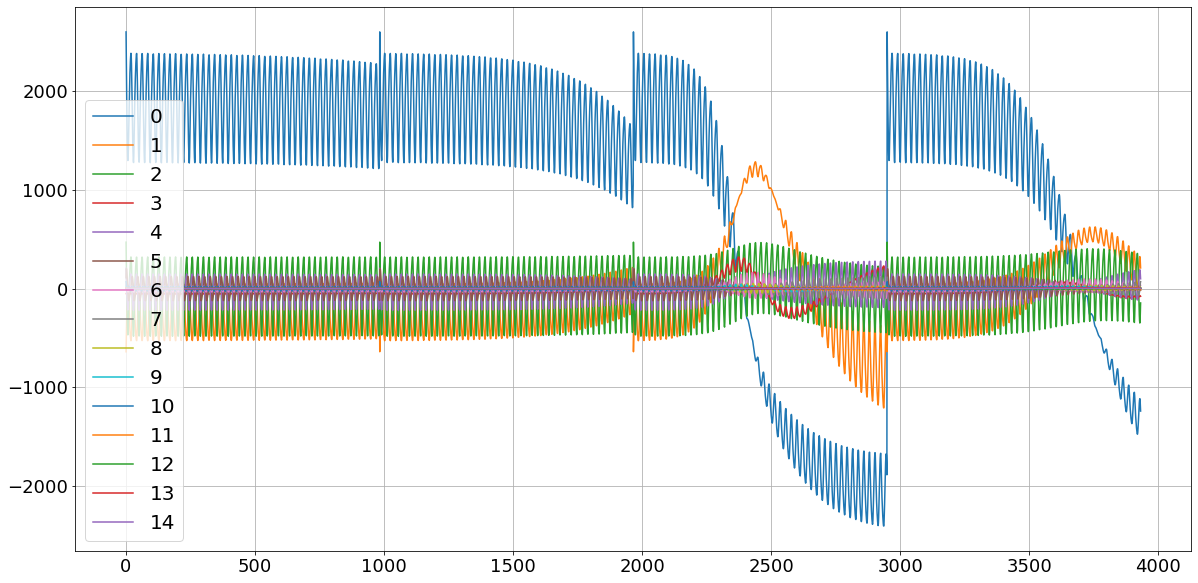

In [52]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(X_test_pca[:len(times)*4]);
ax.grid()
ax.legend(range(15))

In [53]:
def calculateerror(X_train_3D, X_train_3D_recovered, groups, print_step = 0):
    abs_error = abs(X_train_3D - X_train_3D_recovered)
    perc_error = abs_error*100/abs(X_train_3D)
    
    print('max_abs_error: ',np.max(abs(X_train_3D - X_train_3D_recovered)) )
    print('mean_abs_error: ',np.mean(abs(X_train_3D - X_train_3D_recovered)) )
    
    if print_step:
        for time in range(0,X_train_3D.shape[0],print_step):
            print('\ntime: ',time)
            for i, group in enumerate(groups):
                print('Group '+group+': max_abs_error = ',
                      round(np.max(abs_error[time,i,:,:]) ,4),
                      ' %_mae = ',
                      round( np.max(perc_error[time,i,::][np.isfinite(perc_error[time,i,::])]) ,4),
                      '%')

In [54]:
calculateerror(X_test_1D.reshape(nrun*len(times),len(groups),nl,nc), 
               X_recovered.reshape(nrun*len(times),len(groups),nl,nc), 
               groups,
               print_step=0)

max_abs_error:  2.1084948327910915
mean_abs_error:  0.006299254829638481


/home/viluiz/anaconda3/envs/py3ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/viluiz/anaconda3/envs/py3ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


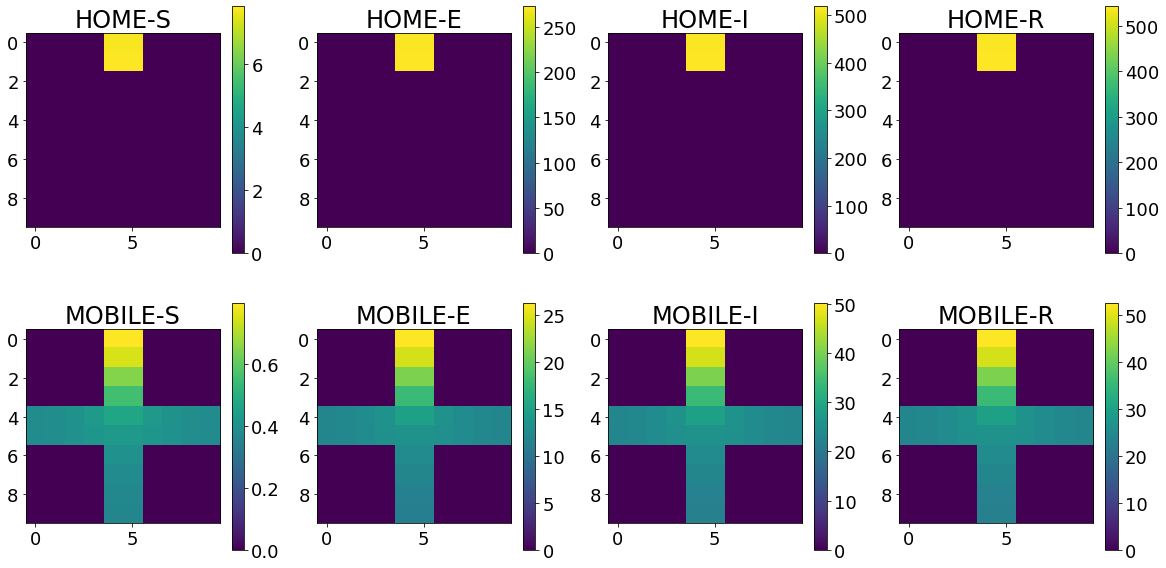

In [55]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_test_1D.reshape(nrun,len(times),len(groups),nl,nc)[4, 500,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

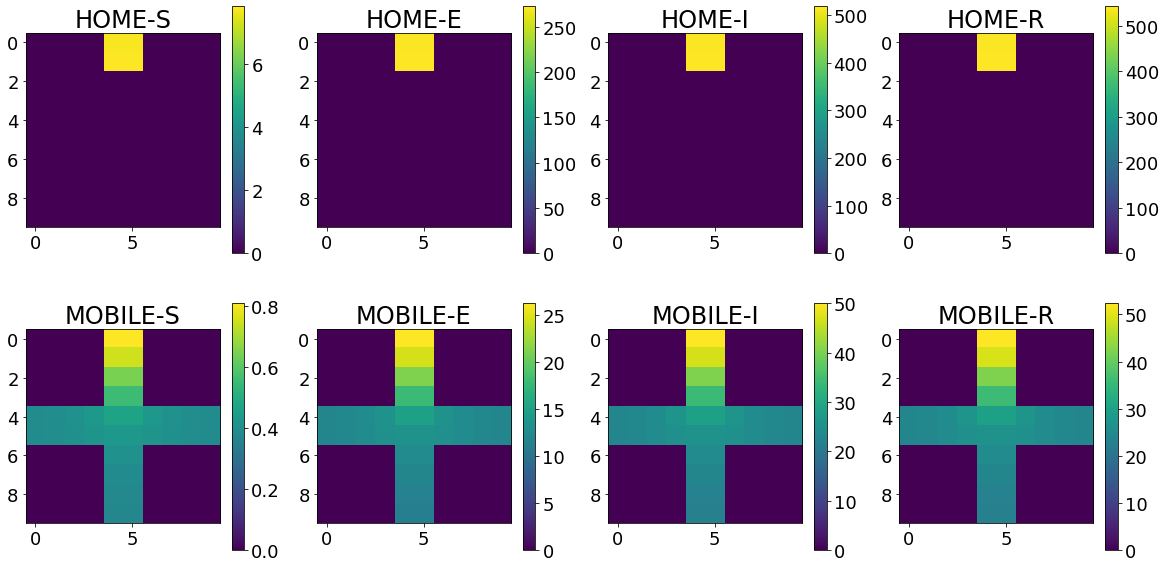

In [56]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_recovered.reshape(nrun, len(times),len(groups),nl,nc)[4, 500,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

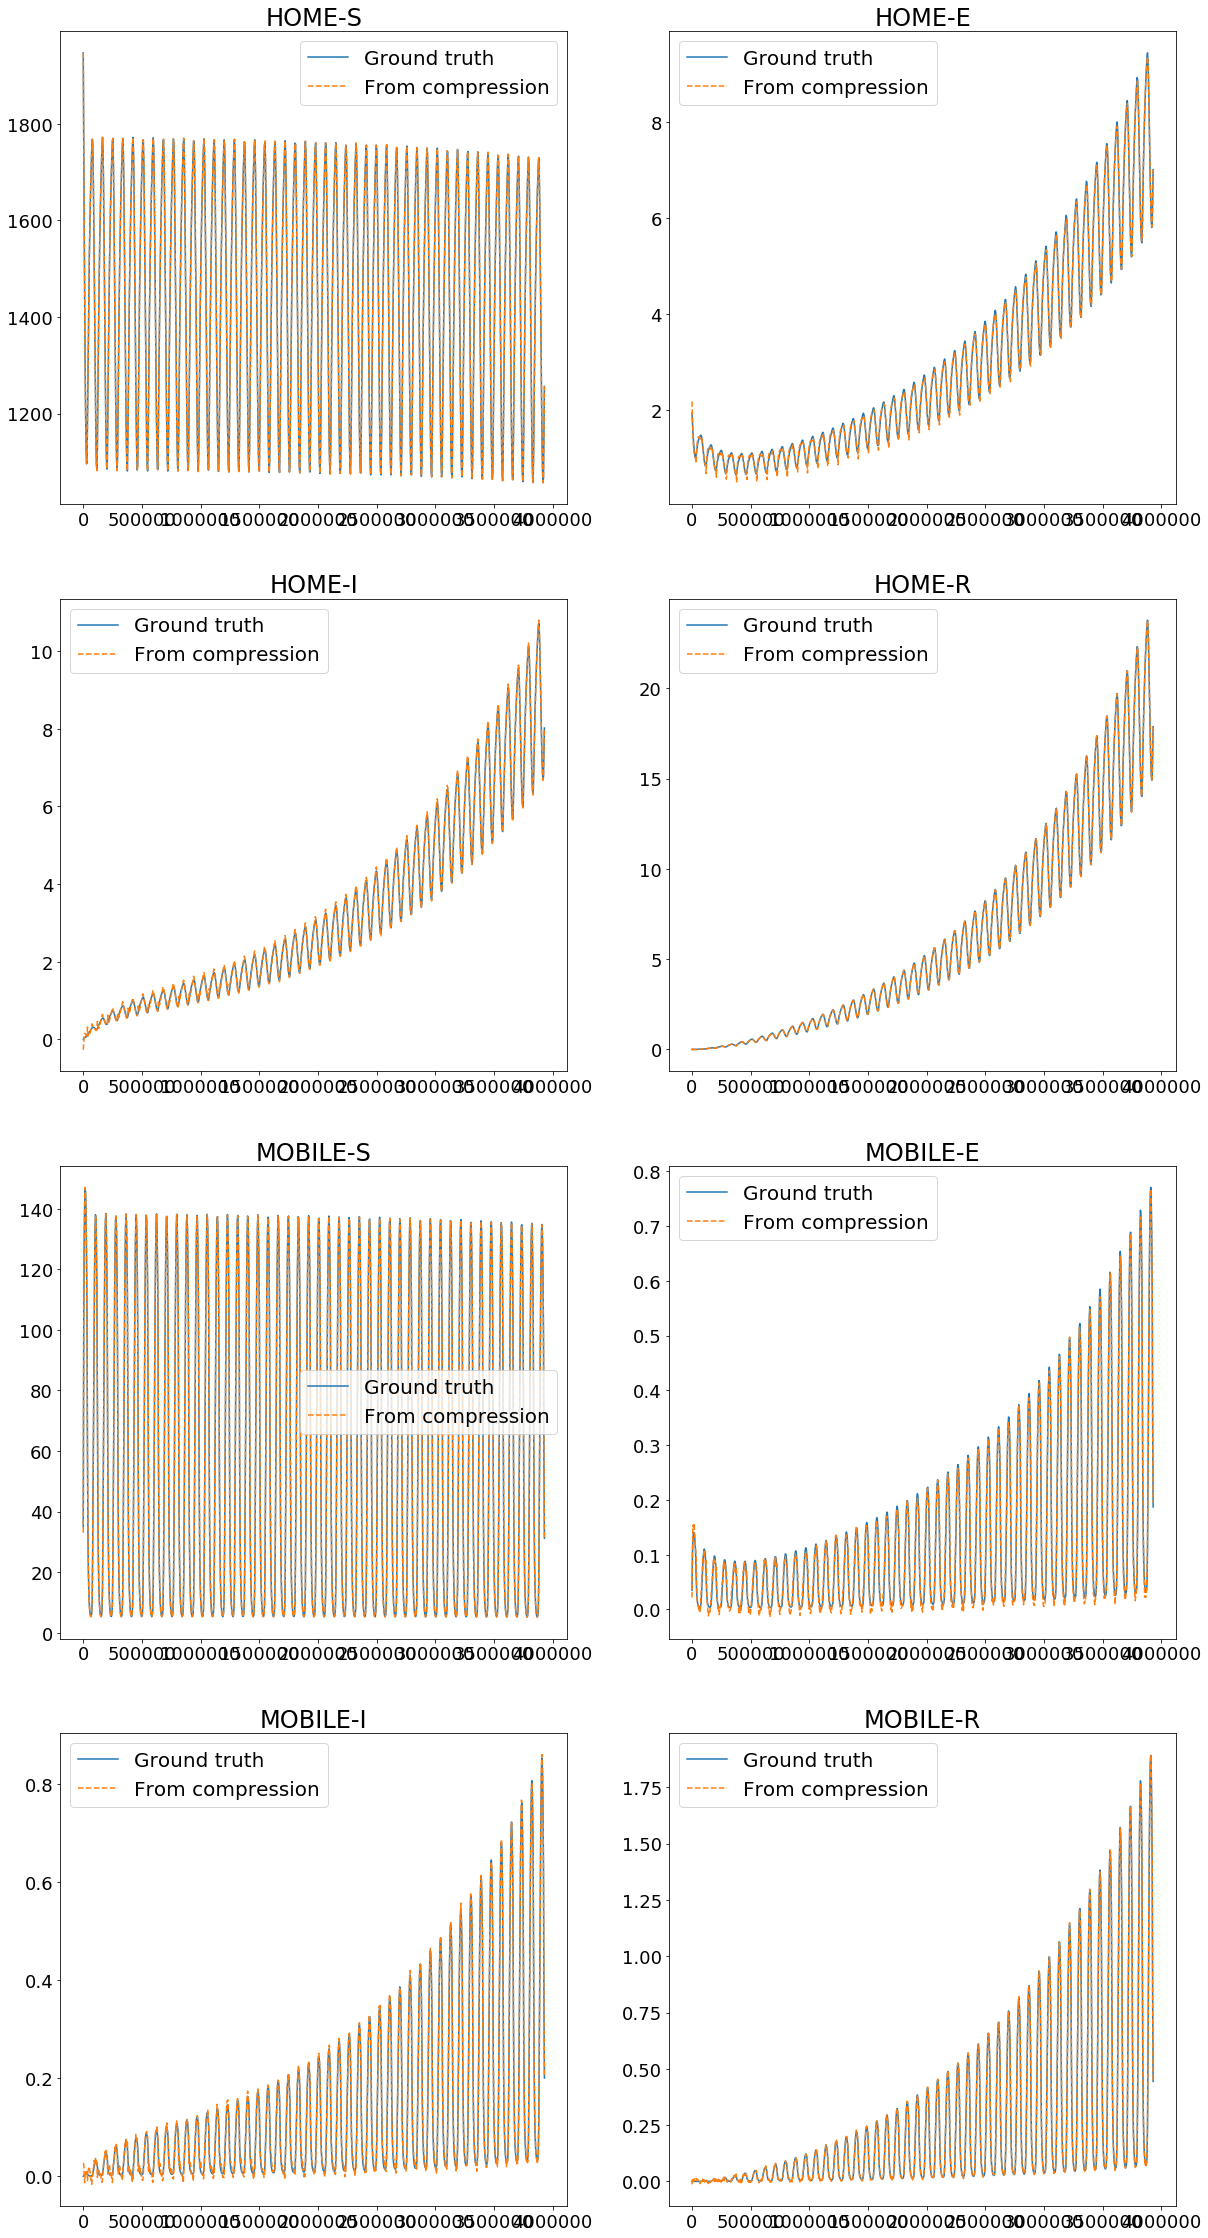

In [57]:
fig, ax = plt.subplots(4,2, figsize=[20,40])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(times, X_test_1D.reshape(nrun, len(times),len(groups),nl,nc)[0,:,i,0,4], label='Ground truth')
    ax.flatten()[i].plot(times, X_recovered.reshape(nrun, len(times),len(groups),nl,nc)[0,:,i,0,4],'--', label='From compression')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()

# Test-uq dataset 

***more 200 simulation for the uncertainty quantification***

In [58]:
times, groups, values = readtimesteps(folder = '../datasets/lots_run_small_normal_200/results_run_1',
                                  prefix = 'group-output-time',
                                  start = 1,
                                  end = 983,
                                  extension = '.csv.gz')

In [59]:
R0 = readR0('../datasets/lots_run_small_normal_200/results_run_1/r0-2values.csv')

In [60]:
times = np.array(times)
values = np.array(values)

print('# of times: ', len(times))
print('# of groups: ', len(groups))
print('values.shape: ', values.shape)
print('R0: ', R0)


# of times:  983
# of groups:  8
values.shape:  (983, 80, 10)
R0:  [7.9555502678, 7.20012447129]


In [61]:
nrun = 200
runs = []
R0s = []
for i in range(nrun):
    times, groups, values = readtimesteps(folder = '../datasets/lots_run_small_normal_200/results_run_' + str(i+1),
                                  prefix = 'group-output-time',
                                  start = 1,
                                  end = 983,
                                  extension = '.csv.gz')
    R0 = readR0('../datasets/lots_run_small_normal_200/results_run_' +str(i+1)+ '/r0-2values.csv')
    runs.append(np.array(values))
    R0s.append(np.array(R0))

In [62]:
np.shape(runs)

(200, 983, 80, 10)

In [63]:
np.shape(R0s)

(200, 2)

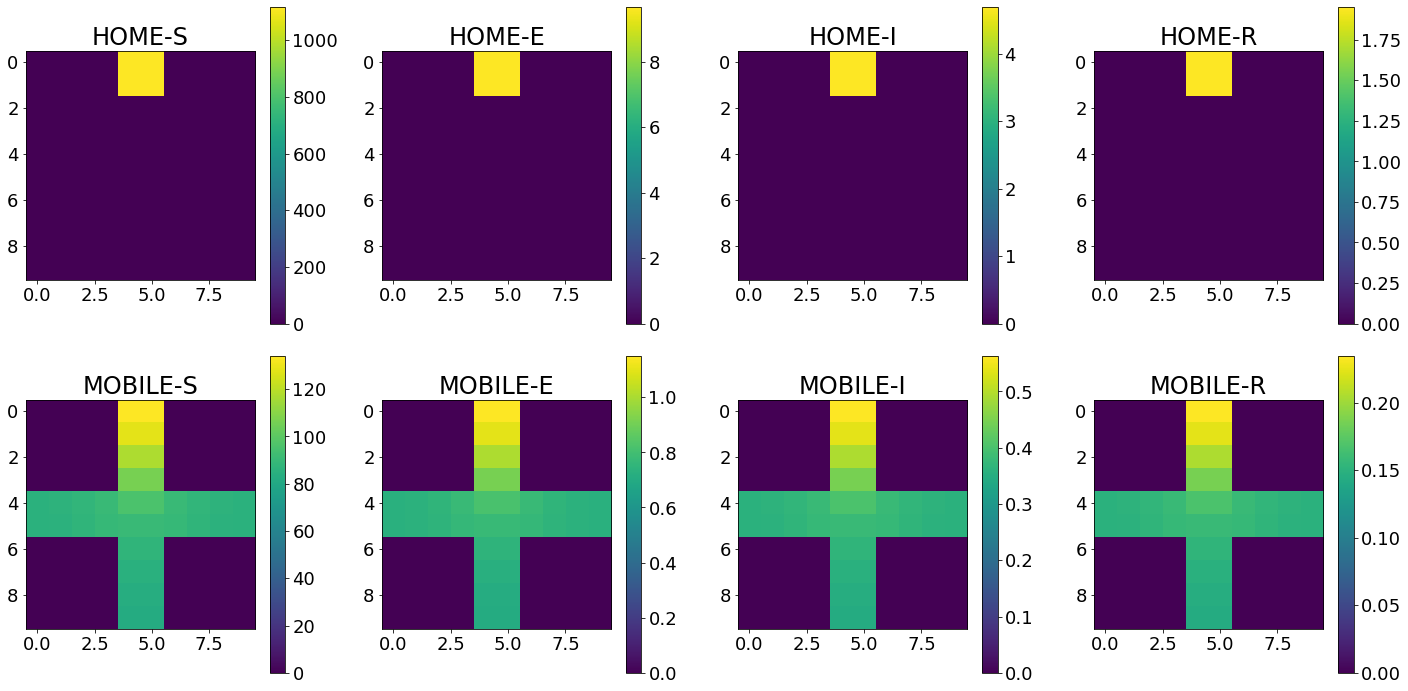

In [64]:
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=18) 
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(runs[0][200,i*10:(i+1)*10,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)
plt.tight_layout()
#plt.savefig('meshnum_2000.png')

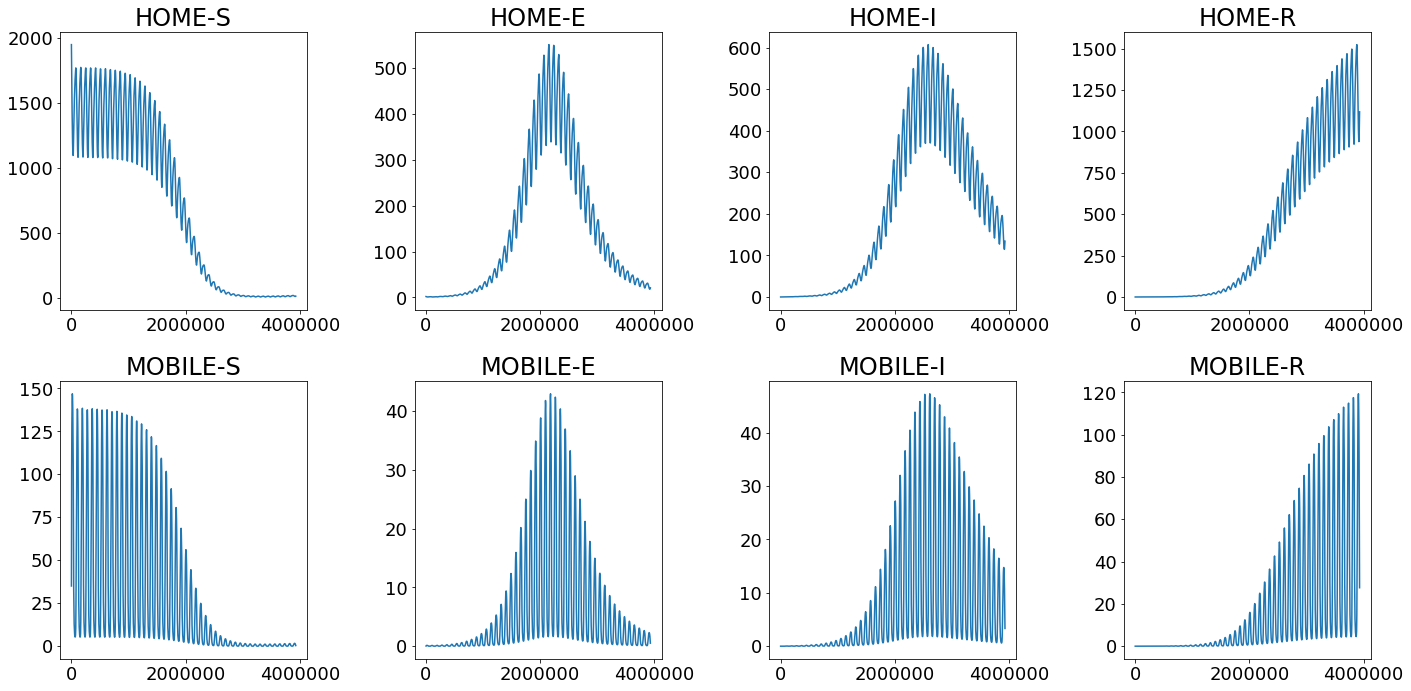

In [65]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(times, runs[0][:,i*10,4])
    ax.flatten()[i].set_title(group)
plt.tight_layout()

## Prepare the data

In [66]:
nl = int(runs[0].shape[-1])
nc = int(runs[0].shape[-2]/len(groups))
print('Grid: ', nl, 'x',nc)

Grid:  10 x 10


In [67]:
X_testuq_2D = np.reshape(runs,(nrun*len(times), len(groups)*nl, nc))

In [68]:
X_testuq_2D.shape

(196600, 80, 10)

In [69]:
X_testuq_3D = X_testuq_2D.reshape(nrun*len(times),len(groups),nl,nc)

In [70]:
X_testuq_3D.shape 

(196600, 8, 10, 10)

In [71]:
X_testuq_1D = X_testuq_2D.reshape(nrun*len(times),len(groups)*nl*nc)

In [72]:
X_testuq_1D.shape

(196600, 800)

In [73]:
import joblib

np.savetxt('X_testuq_1D.csv', X_testuq_1D, delimiter=',') 
np.savetxt('R0s_testuq.csv', R0s, delimiter=',') 
#np.savetxt('times.csv', times, delimiter=',') 
#with open('groups.txt','w') as f:
#    f.writelines([g + '\n' for g in groups])

#pca_compress = joblib.load("pca_compress_15.pkl") 
X_testuq_pca = pca_compress.transform(X_testuq_1D)
np.savetxt('X_testuq_pca.csv', X_testuq_pca, delimiter=',') 
X_recovered = pca_compress.inverse_transform(X_testuq_pca)
np.allclose(X_recovered, X_testuq_1D)

False

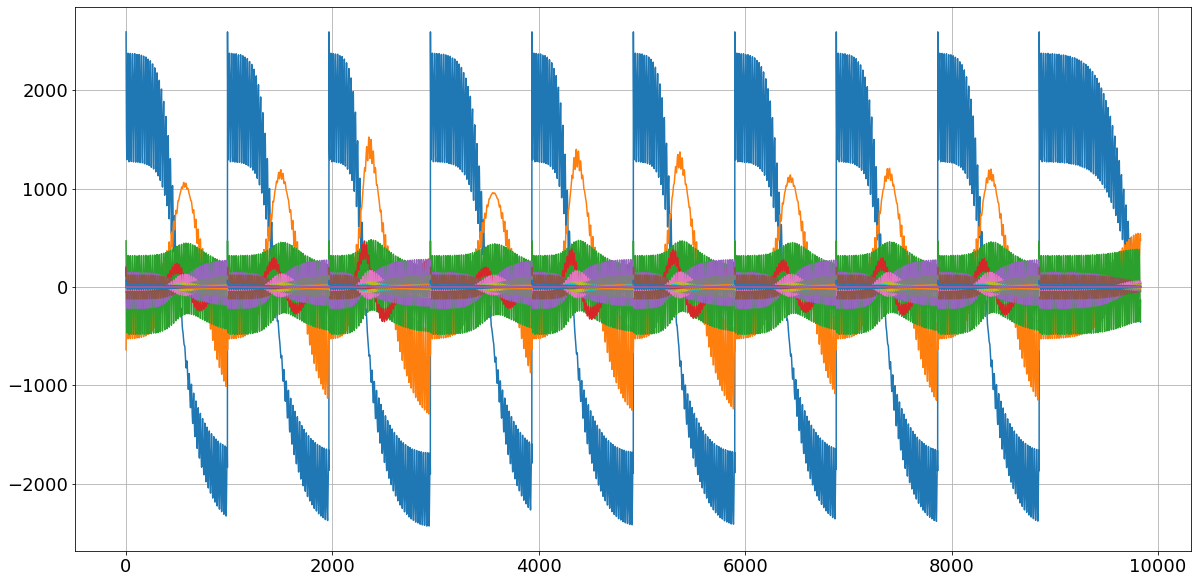

In [74]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(X_testuq_pca[:len(times)*10]);
ax.grid()
#ax.legend(range(15))

In [75]:
def calculateerror(X_train_3D, X_train_3D_recovered, groups, print_step = 0):
    abs_error = abs(X_train_3D - X_train_3D_recovered)
    perc_error = abs_error*100/abs(X_train_3D)
    
    print('max_abs_error: ',np.max(abs(X_train_3D - X_train_3D_recovered)) )
    print('mean_abs_error: ',np.mean(abs(X_train_3D - X_train_3D_recovered)) )
    
    if print_step:
        for time in range(0,X_train_3D.shape[0],print_step):
            print('\ntime: ',time)
            for i, group in enumerate(groups):
                print('Group '+group+': max_abs_error = ',
                      round(np.max(abs_error[time,i,:,:]) ,4),
                      ' %_mae = ',
                      round( np.max(perc_error[time,i,::][np.isfinite(perc_error[time,i,::])]) ,4),
                      '%')

In [76]:
calculateerror(X_testuq_1D.reshape(nrun*len(times),len(groups),nl,nc), 
               X_recovered.reshape(nrun*len(times),len(groups),nl,nc), 
               groups,
               print_step=0)

/home/viluiz/anaconda3/envs/py3ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/viluiz/anaconda3/envs/py3ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


max_abs_error:  2.1084948327910915
mean_abs_error:  0.0062247519030968704


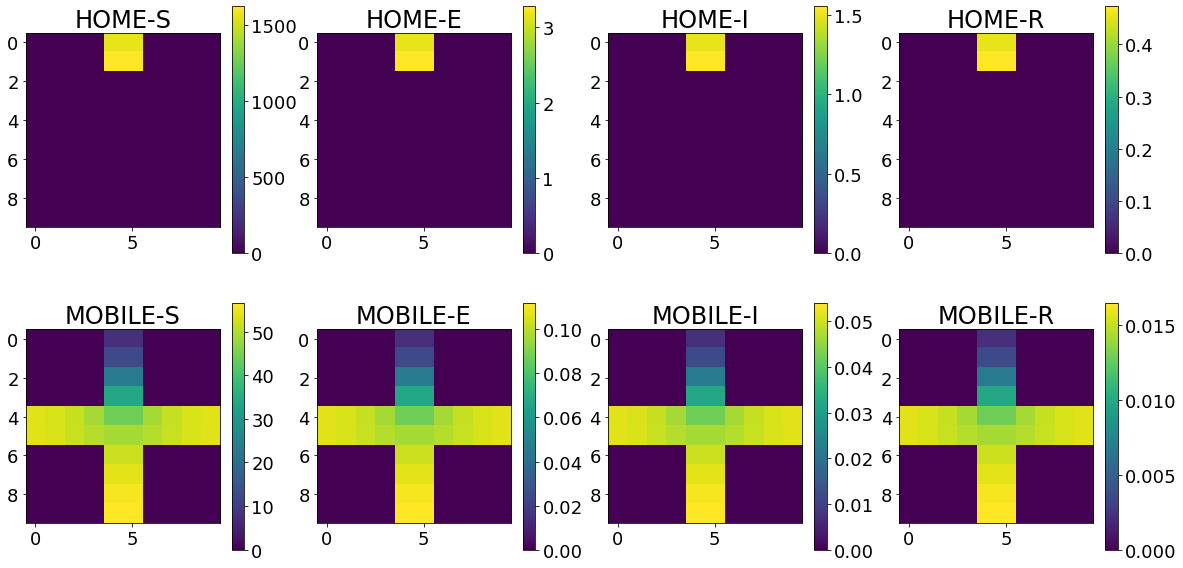

In [77]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_testuq_1D.reshape(nrun,len(times),len(groups),nl,nc)[0, 100,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

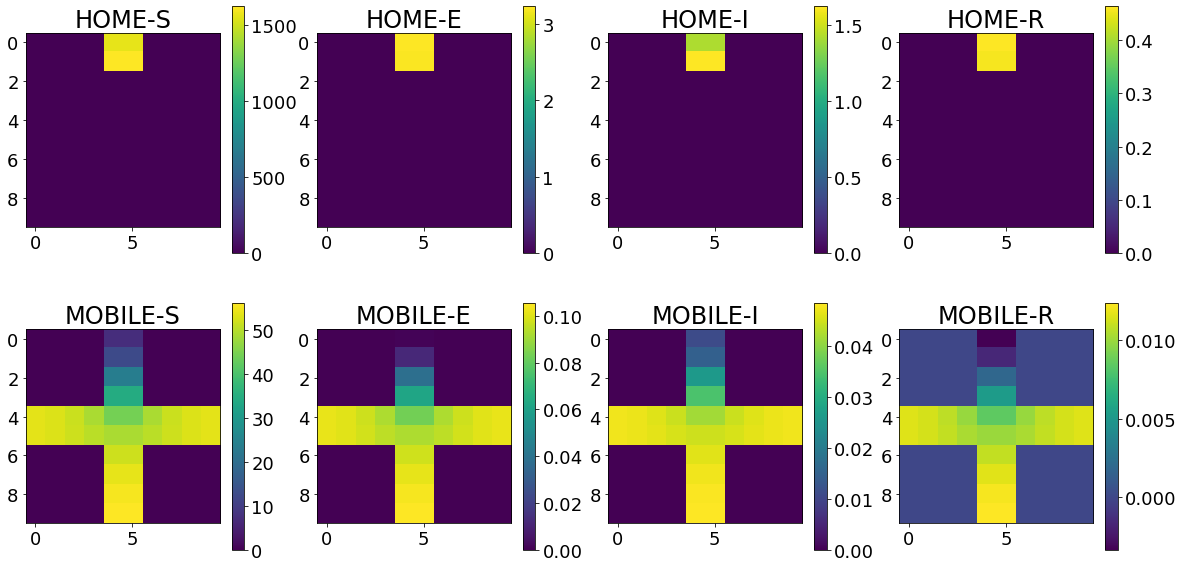

In [78]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_recovered.reshape(nrun, len(times),len(groups),nl,nc)[0, 100,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

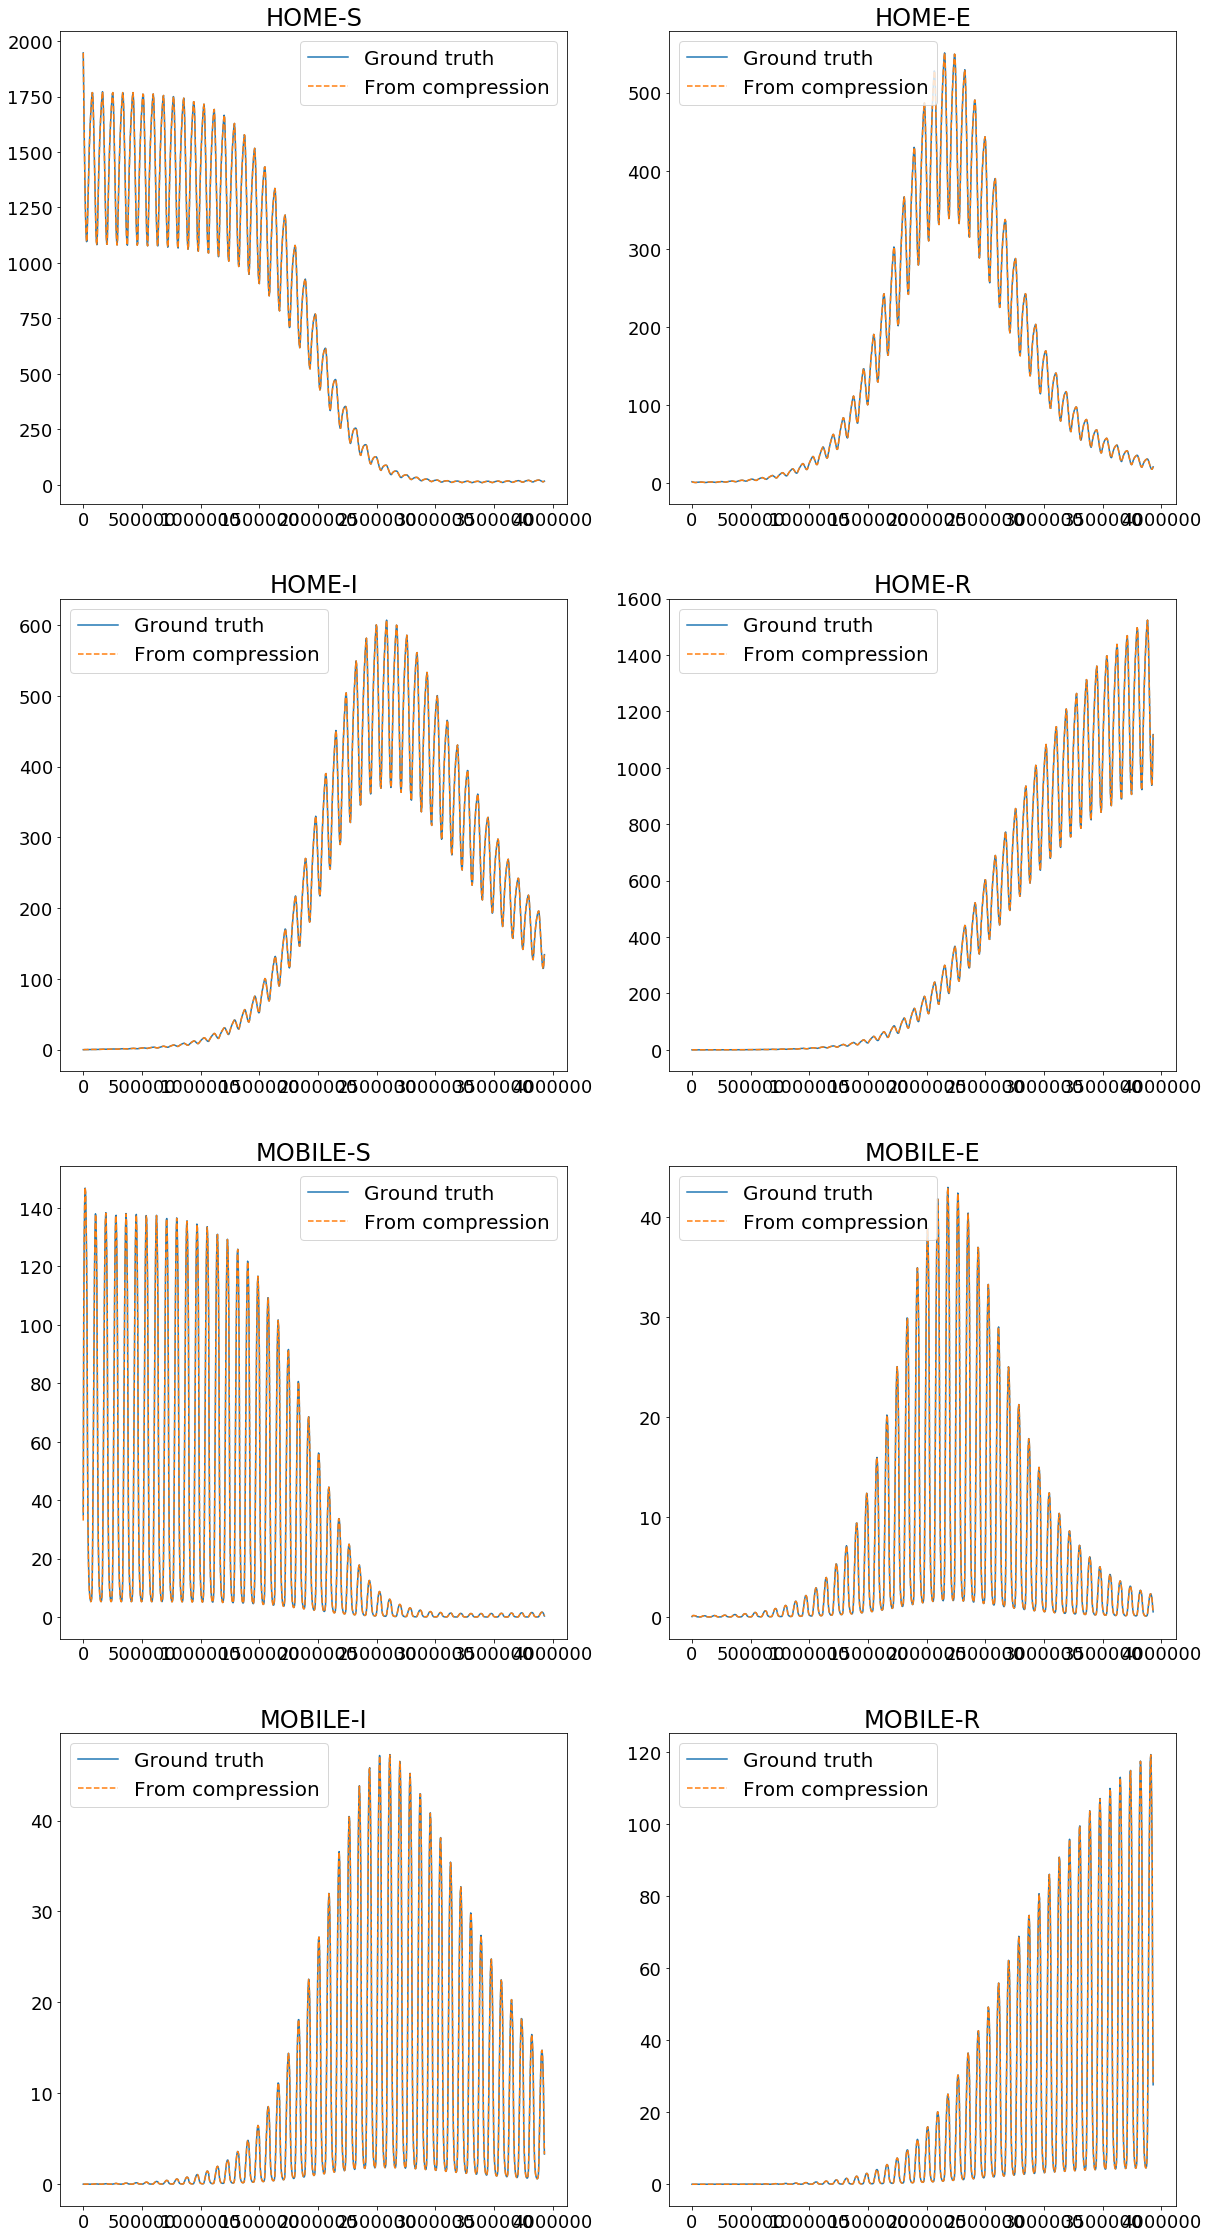

In [79]:
fig, ax = plt.subplots(4,2, figsize=[20,40])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(times, X_testuq_1D.reshape(nrun, len(times),len(groups),nl,nc)[0,:,i,0,4], label='Ground truth')
    ax.flatten()[i].plot(times, X_recovered.reshape(nrun, len(times),len(groups),nl,nc)[0,:,i,0,4],'--', label='From compression')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()